# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: [2025AA05787]

Name: [RUDRESH R]

Email: [2025AA05787@wilp.bits-pilani.ac.in]

Date: [4/2/2026]

In [1]:
# Import Required Libraries
%pip install numpy pandas matplotlib seaborn scikit-learn tensorflow keras Pillow opencv-python



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os

print("All required libraries imported successfully")


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


All required libraries imported successfully


In [2]:
# Deep learning frameworks (choose Keras or PyTorch)
# For image processing

from PIL import Image
import cv2

print("Pillow and OpenCV imported successfully")

Pillow and OpenCV imported successfully


### 1.1 Dataset Selection and Loading

TODO: Load your chosen dataset

In [3]:
# REQUIRED: Fill in these metadata fields
dataset_name = "Jute Pest Classification"
dataset_source = "UCI https://archive.ics.uci.edu/dataset/920/jute+pest+dataset"
n_samples = 1699  # Total number of images
n_classes = 3  #  Number of classes - Jute Aphid, Jute Stem Weevil, Mealybug
samples_per_class = "min: 501, max: 667, avg: 566"
image_shape = [256, 256, 3]  # [height, width, channels]
problem_type = "classification"

In [4]:
# Primary metric selection
primary_metric = "Recall"
metric_justification = """Recall is selected as the primary metric because, in the context of pest detection, failing to identify an actual pest infection can result in significant crop loss or economic damage. Prioritizing recall ensures that most true pest cases are detected, minimizing the risk of missing critical infections.
"""

In [5]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Jute Pest Classification
Source: UCI https://archive.ics.uci.edu/dataset/920/jute+pest+dataset
Total Samples: 1699
Number of Classes: 3
Samples per Class: min: 501, max: 667, avg: 566
Image Shape: [256, 256, 3]
Primary Metric: Recall
Metric Justification: Recall is selected as the primary metric because, in the context of pest detection, failing to identify an actual pest infection can result in significant crop loss or economic damage. Prioritizing recall ensures that most true pest cases are detected, minimizing the risk of missing critical infections.



### 1.2 Data Exploration and Visualization

- Show sample images from each class
- Plot class distribution
- Display image statistics

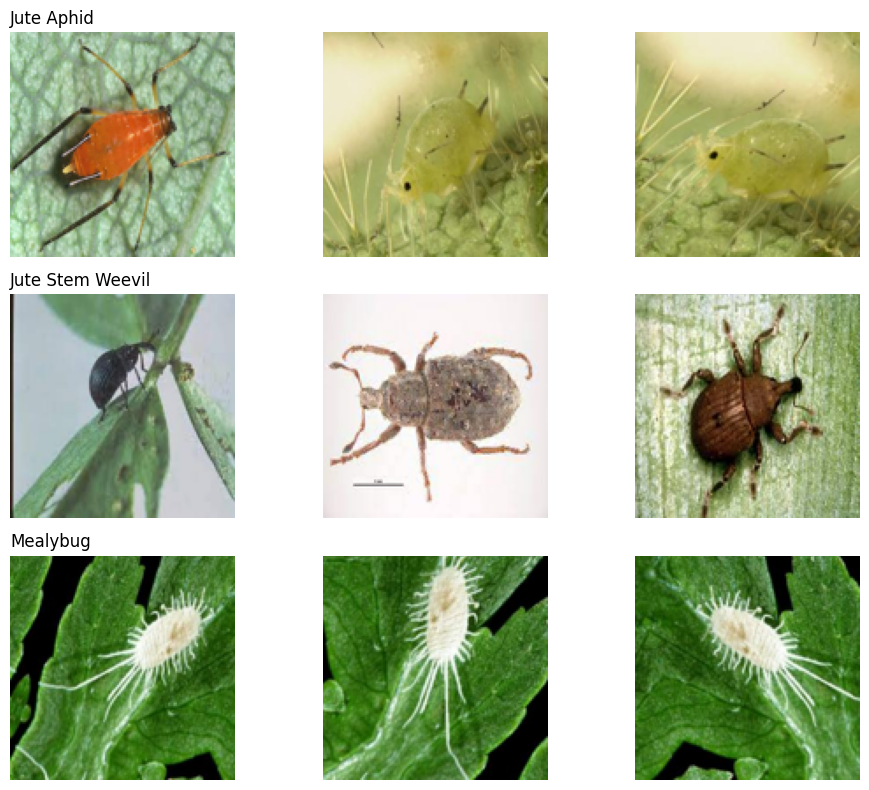

C:\Users\rramal4\AppData\Local\Temp\ipykernel_39716\1883647353.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts, palette="viridis")


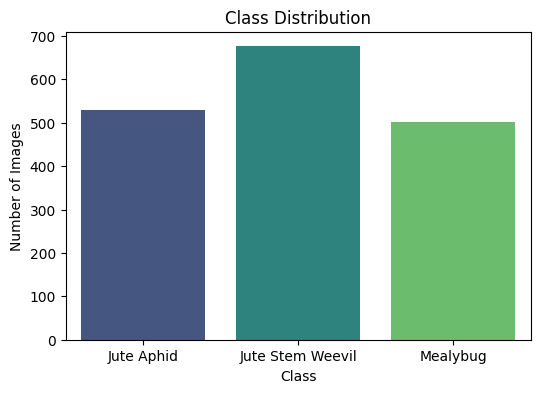

Image Statistics per Class:

Class: Jute Aphid
  Num images (scanned): 530
  Avg Height: 373.9 px
  Avg Width: 376.1 px
  Mean Pixel Value (R,G,B): [124.7 131.3  82.4]
  Stddev Pixel Value (R,G,B): [48.1 45.7 43. ]

Class: Jute Stem Weevil
  Num images (scanned): 676
  Avg Height: 433.5 px
  Avg Width: 433.9 px
  Mean Pixel Value (R,G,B): [140.7 148.4 112.5]
  Stddev Pixel Value (R,G,B): [51.1 51.3 49.7]

Class: Mealybug
  Num images (scanned): 501
  Avg Height: 364.9 px
  Avg Width: 366.6 px
  Mean Pixel Value (R,G,B): [107.9 113.6  83.8]
  Stddev Pixel Value (R,G,B): [54.8 54.  60. ]


In [6]:
from PIL import ImageStat

# Path to your training data
train_dir = "jute_pest_train/train"
class_names = ["Jute Aphid", "Jute Stem Weevil", "Mealybug"]

fig, axes = plt.subplots(len(class_names), 3, figsize=(10, 8))
for row, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:3]
    for col, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).resize((128, 128))
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(class_name, fontsize=12, loc='left')
plt.tight_layout()
plt.show()

# Plot class distribution
class_counts = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    class_counts.append(count)

plt.figure(figsize=(6, 4))
sns.barplot(x=class_names, y=class_counts, palette="viridis")
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.show()


# Print key statistics for images in each class

print("Image Statistics per Class:")
for cname in class_names:
    cpath = os.path.join(train_dir, cname)
    img_files = [f for f in os.listdir(cpath) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sample_imgs = img_files # Use up to 400 images per class for stats
    heights, widths, means, stds = [], [], [], []
    for fname in sample_imgs:
        img = Image.open(os.path.join(cpath, fname)).convert('RGB')
        arr = np.array(img)
        heights.append(arr.shape[0])
        widths.append(arr.shape[1])
        stat = ImageStat.Stat(img)
        means.append(stat.mean)
        stds.append(stat.stddev)
    print(f"\nClass: {cname}")
    print(f"  Num images (scanned): {len(sample_imgs)}")
    print(f"  Avg Height: {np.mean(heights):.1f} px")
    print(f"  Avg Width: {np.mean(widths):.1f} px")
    print(f"  Mean Pixel Value (R,G,B): {np.mean(means, axis=0).round(1)}")
    print(f"  Stddev Pixel Value (R,G,B): {np.mean(stds, axis=0).round(1)}")






### 1.3 Data Preprocessing
- TODO: Resize images to consistent size
- TODO: Normalize pixel values
- TODO: Split into train/test (90/10 or 85/15)

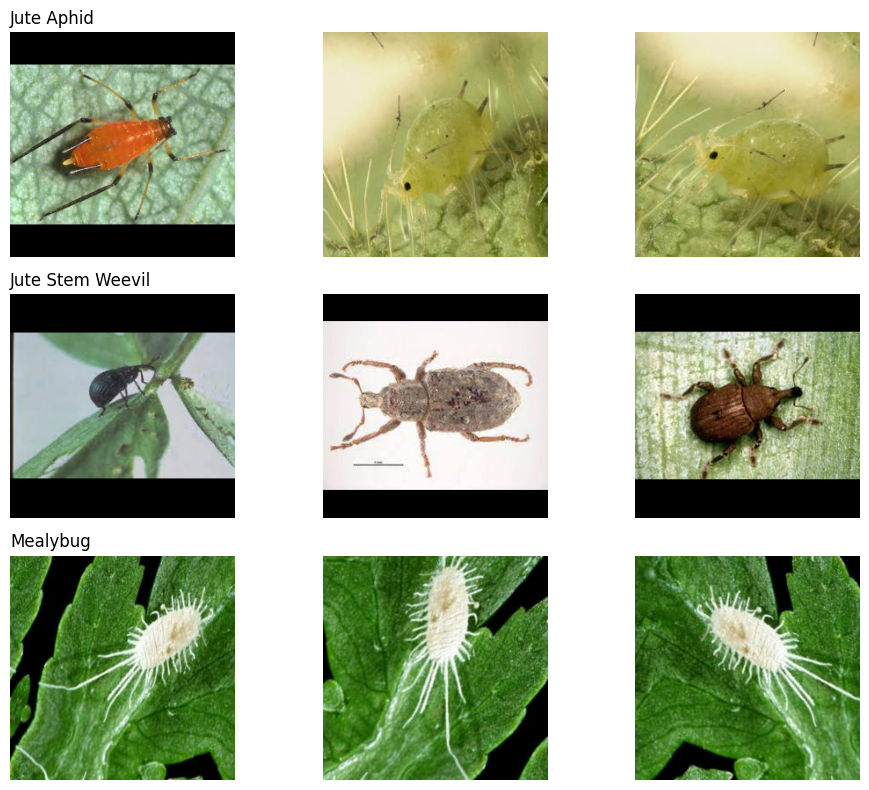

Preprocessing Summary:
Target image size: (256, 256, 3)
Average image width after resizing: 256.0 px
Average image height after resizing: 256.0 px
Class counts: {'Jute Aphid': 530, 'Jute Stem Weevil': 676, 'Mealybug': 501}
Total images: 1707


In [7]:

import cv2

def resize_with_padding(img_array, target_size=(256, 256)):
    """
    Resize an image (numpy array) to target_size with outer padding, keeping aspect ratio.
    Args:
        img_array: numpy array (H, W, 3)
        target_size: tuple (height, width)
    Returns:
        padded_img: numpy array (target_size[0], target_size[1], 3)
    """
    h, w = img_array.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(img_array, (new_w, new_h), interpolation=cv2.INTER_AREA)
    pad_h = target_size[0] - new_h
    pad_w = target_size[1] - new_w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    padded_img = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
    return padded_img

# Example usage for your arr variable:
resized_img = resize_with_padding(arr, target_size=(256, 256))

# Normalize pixel values to [0, 1]
normalized_img = resized_img.astype(np.float32) / 255.0
all_widths = []
all_heights = []
# Display sample resized and normalized images for each class
fig, axes = plt.subplots(len(class_names), 3, figsize=(10, 8))
for row, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:3]
    for col, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).convert('RGB')
        arr = np.array(img)
        resized_img = resize_with_padding(arr, target_size=(256, 256))
        normalized_img = resized_img.astype(np.float32) / 255.0
        all_heights.append(resized_img.shape[0])
        all_widths.append(resized_img.shape[1])
        axes[row, col].imshow(normalized_img)
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(class_name, fontsize=12, loc='left')
plt.tight_layout()
plt.show()


# Print summary statistics after preprocessing
print("Preprocessing Summary:")
print(f"Target image size: {resized_img.shape}")
print(f"Average image width after resizing: {np.mean(all_widths):.1f} px")
print(f"Average image height after resizing: {np.mean(all_heights):.1f} px")
print(f"Class counts: {dict(zip(class_names, class_counts))}")
print(f"Total images: {sum(class_counts)}")

In [8]:
# REQUIRED: Document your split
train_test_ratio = "90/10"
train_samples = 1673  # TODO: Number of training samples
test_samples = 203  # TODO: Number of test samples

In [9]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 90/10
Training Samples: 1673
Test Samples: 203


### 2.1 Custom CNN Architecture Design
- TODO: Define your CNN architecture
- TODO: Ensure Global Average Pooling is included (MANDATORY)
- TODO: Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [10]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense


def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture

    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled CNN model
    """
   
 
    model = Sequential([
            # First convolutional block
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            MaxPooling2D((2, 2)),

            # Additional convolutional block (inserted)
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),

            # Second (original) convolutional block (now third)
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),

            # Global Average Pooling layer
            GlobalAveragePooling2D(),

            # Output layer
            Dense(n_classes, activation='softmax')
        ])

    return model

   


In [11]:
# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

c:\Program Files\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
#Compile model
# For Keras: model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# For PyTorch: define optimizer and loss function


custom_cnn.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['recall'])

print("\nModel Architecture:")
custom_cnn.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,635 (365.76 KB)

 Trainable params: 93,635 (365.76 KB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Train Custom CNN

In [13]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#  Train your model
# For Keras: history = custom_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
# For PyTorch: write training loop

def load_images_from_folder(folder, class_names, target_size=(256, 256)):
    X, y = [], []
    for idx, cname in enumerate(class_names):
        class_folder = os.path.join(folder, cname)
        for fname in os.listdir(class_folder):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_folder, fname)
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size)
                arr = np.array(img).astype(np.float32) / 255.0
                X.append(arr)
                y.append(idx)
    return np.array(X), np.array(y)

# Load train, val, test sets
train_folder = "jute_pest_train/train"
val_folder = "jute_pest_train/val"
test_folder = "jute_pest_train/test"

X_train, y_train = load_images_from_folder(train_folder, class_names, target_size=(256, 256))
X_val, y_val = load_images_from_folder(val_folder, class_names, target_size=(256, 256))
X_test, y_test = load_images_from_folder(test_folder, class_names, target_size=(256, 256))

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=n_classes)
y_val = to_categorical(y_val, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()

history = custom_cnn.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

custom_cnn_training_time = time.time() - custom_cnn_start_time



CUSTOM CNN TRAINING
Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 1.0331 - recall: 0.1777 - val_loss: 1.4613 - val_recall: 0.0000e+00
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.9967 - recall: 0.2767 - val_loss: 1.3201 - val_recall: 0.0000e+00
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - loss: 0.9714 - recall: 0.3372 - val_loss: 1.2172 - val_recall: 0.0175
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - loss: 0.9433 - recall: 0.3665 - val_loss: 1.2064 - val_recall: 0.0526
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.9193 - recall: 0.3698 - val_loss: 1.4984 - val_recall: 0.0175
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 0.8788 - recall: 0.4310 - val_loss: 1.1090 - val_recall: 0.2222
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - loss: 0.8685 - recall: 0.4499 - val_loss: 1.2265 - val_recall: 0.2164
Epoch 8/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 822ms/step - loss: 0.8097 - recall: 0.5052 - val_loss: 1.1400 - val_recall

In [14]:
# REQUIRED: Track initial and final loss
custom_cnn_initial_loss = history.history['loss'][0]
custom_cnn_final_loss = history.history['loss'][-1]


In [15]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 1312.14 seconds
Initial Loss: 1.0331
Final Loss: 0.4675


### 2.3 Evaluate Custom CNN
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [16]:
# CRITICAL: These MUST be calculated from your actual results
# DO NOT submit with 0.0 values - autograder will detect this
# REQUIRED: Calculate all 4 metrics

print("\nCUSTOM CNN EVALUATION")

# Predict on test set
y_pred_probs = custom_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
custom_cnn_accuracy = accuracy_score(y_true, y_pred)
custom_cnn_precision = precision_score(y_true, y_pred, average='weighted')
custom_cnn_recall = recall_score(y_true, y_pred, average='weighted')
custom_cnn_f1 = f1_score(y_true, y_pred, average='weighted')


CUSTOM CNN EVALUATION
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step


In [17]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Custom CNN Performance:
Accuracy:  0.7241
Precision: 0.7284
Recall:    0.7241
F1-Score:  0.7106


### 2.4 Visualize Custom CNN Results
- TODO: Plot training loss curve
- TODO: Plot confusion matrix
- TODO: Show sample predictions

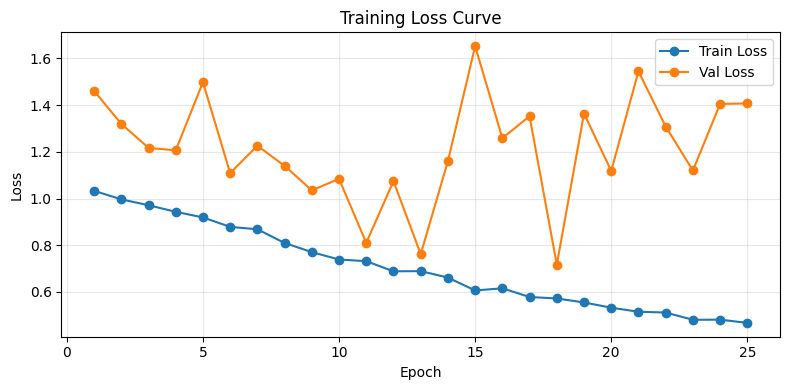

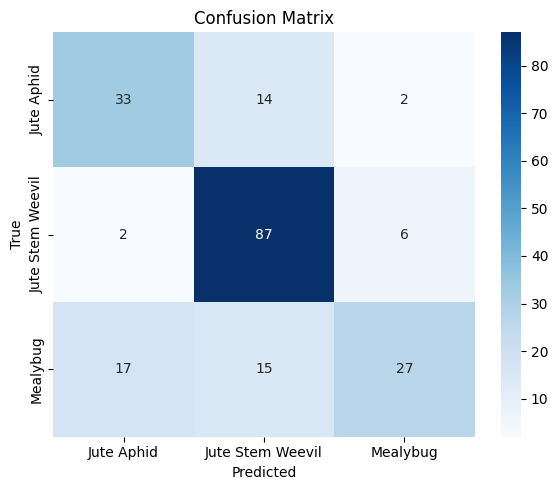

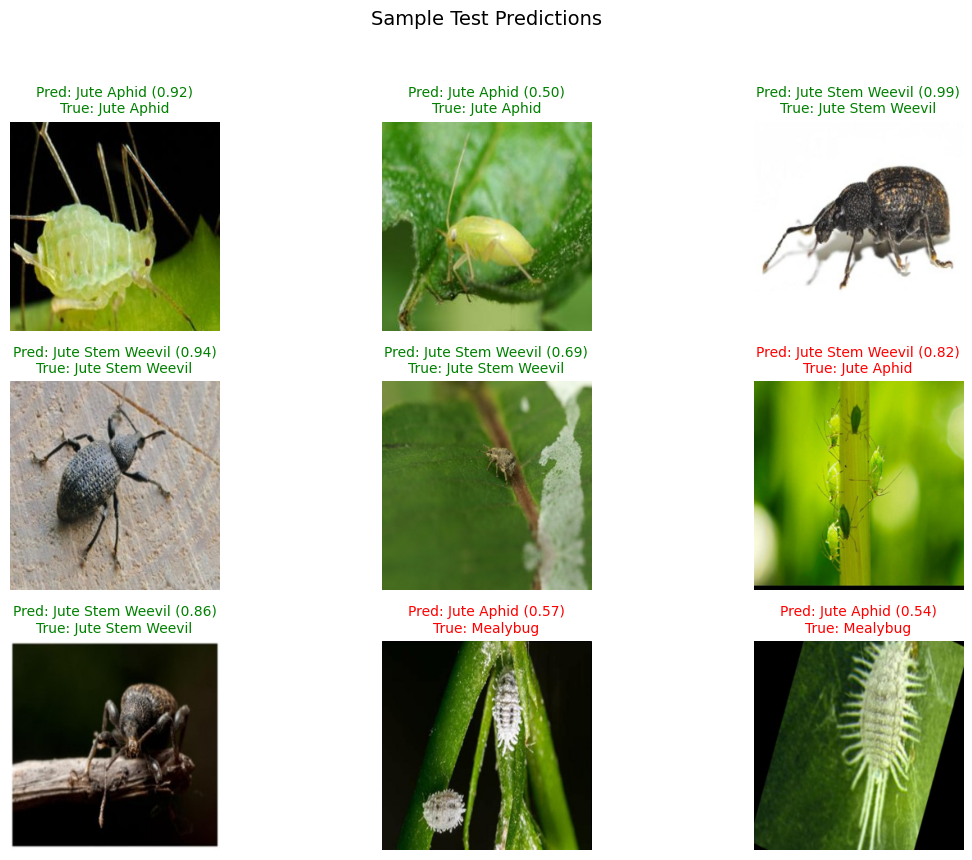

In [18]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training loss curve, confusion matrix, and show sample predictions

import matplotlib.pyplot as plt

# 1) Training epoch loss curve
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', None)
epochs = np.arange(1, len(loss) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, marker='o', label='Train Loss')
if val_loss is not None:
    plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# 2) Confusion matrix
cnn_cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# 3) Sample predictions (up to 9)
pred_n_samples = min(9, len(X_test))
np.random.seed(42)
idxs = np.random.choice(len(X_test), size=pred_n_samples, replace=False)

cols = 3
rows = int(np.ceil(pred_n_samples / cols))
plt.figure(figsize=(cols * 4, rows * 3))

for i, idx in enumerate(idxs):
    img = X_test[idx]
    # If image was normalized to [0,1], display directly; else clip
    disp_img = np.clip(img, 0.0, 1.0)
    pred_label = class_names[int(y_pred[idx])]
    true_label = class_names[int(y_true[idx])]
    pred_prob = float(y_pred_probs[idx][int(y_pred[idx])])

    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(disp_img)
    ax.axis('off')
    correct = (pred_label == true_label)
    title_color = 'green' if correct else 'red'
    ax.set_title(f"Pred: {pred_label} ({pred_prob:.2f})\nTrue: {true_label}",
                 color=title_color, fontsize=10)

plt.suptitle('Sample Test Predictions', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 3.1 Load Pre-trained Model and Modify Architecture

In [19]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")
# Choose and load pre-trained model
pretrained_model_name = "ResNet50"


TRANSFER LEARNING IMPLEMENTATION


In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam

def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model
    
    Args:
        base_model_name: string (ResNet18/ResNet50/VGG16/VGG19)
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled transfer learning model
    """
    # Load pre-trained model without top layers
    if base_model_name.lower() in ["resnet18", "resnet50"]:
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_tensor=Input(shape=input_shape)
        )
    elif base_model_name.lower() == "vgg16":
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_tensor=Input(shape=input_shape)
        )
    elif base_model_name.lower() == "vgg19":
        base_model = VGG19(
            weights='imagenet',
            include_top=False,
            input_tensor=Input(shape=input_shape)
        )
    else:
        raise ValueError("Unsupported base_model_name. Use ResNet18/ResNet50/VGG16/VGG19.")

    
    # Freeze all base model layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Use only Global Average Pooling as the head (no intermediate Dense/Flatten)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile with lower learning rate for transfer learning
    model.compile(
        optimizer=Adam(learning_rate=1e-4),  # Much lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy', 'Recall']
    )

    return model

In [21]:
# Create transfer learning model

transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)

In [22]:
from tensorflow.keras import backend as K
import numpy as np

# REQUIRED: Count layers and parameters
# Count frozen/trainable layers and parameters for transfer_model
frozen_layers = sum(1 for layer in transfer_model.layers if not layer.trainable)
trainable_layers = sum(1 for layer in transfer_model.layers if layer.trainable)
total_parameters = int(transfer_model.count_params())
trainable_parameters = int(np.sum([K.count_params(w) for w in transfer_model.trainable_weights]))


In [23]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

Base Model: ResNet50
Frozen Layers: 175
Trainable Layers: 2
Total Parameters: 23,593,859
Trainable Parameters: 6,147
Using Global Average Pooling: YES


### 3.2 Train Transfer Learning Model

In [24]:
print("\nTraining Transfer Learning Model...")


Training Transfer Learning Model...


In [ ]:
# Training configuration
tl_learning_rate = 0.001  # Changed from 0.1 to 0.001 (much better for transfer learning)
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = "Adam"

In [26]:
# TODO: Train model
# For Keras: history = transfer_model.fit(X_train, y_train, epochs=10, batch_size=32)
# For PyTorch: write training loop
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# IMPORTANT: Reload data to avoid double-preprocessing corruption
# Only preprocess ONCE, not multiple times!
print("Reloading and preprocessing data for ResNet50...")

X_train_tl, y_train_tl = load_images_from_folder(train_folder, class_names, target_size=(256, 256))
X_val_tl, y_val_tl = load_images_from_folder(val_folder, class_names, target_size=(256, 256))
X_test_tl, y_test_tl = load_images_from_folder(test_folder, class_names, target_size=(256, 256))

# Apply ResNet50 preprocessing (expects [0,255] range, NOT [0,1])
X_train_tl = preprocess_input((X_train_tl * 255.0).astype(np.float32))
X_val_tl = preprocess_input((X_val_tl * 255.0).astype(np.float32))
X_test_tl = preprocess_input((X_test_tl * 255.0).astype(np.float32))

# One-hot encode labels
y_train_tl = to_categorical(y_train_tl, num_classes=n_classes)
y_val_tl = to_categorical(y_val_tl, num_classes=n_classes)
y_test_tl = to_categorical(y_test_tl, num_classes=n_classes)


# Track training time
tl_start_time = time.time()

history_tl = transfer_model.fit(
    X_train_tl, y_train_tl,
    epochs=tl_epochs,
    batch_size=tl_batch_size,
    validation_data=(X_val_tl, y_val_tl),
    verbose=1
)
tl_training_time = time.time() - tl_start_time

print("\nTransfer learning training completed!")

Reloading and preprocessing data for ResNet50...
Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - Recall: 0.2982 - accuracy: 0.4230 - loss: 1.2066 - val_Recall: 0.4662 - val_accuracy: 0.6090 - val_loss: 0.8519
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - Recall: 0.5764 - accuracy: 0.6907 - loss: 0.7150 - val_Recall: 0.7143 - val_accuracy: 0.7970 - val_loss: 0.5401
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - Recall: 0.7475 - accuracy: 0.8307 - loss: 0.4900 - val_Recall: 0.7895 - val_accuracy: 0.8797 - val_loss: 0.3831
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - Recall: 0.8489 - accuracy: 0.8946 - loss: 0.3661 - val_Recall: 0.8722 - val_accuracy: 0.9173 - val_loss: 0.2966
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - Recall: 0.8881 - accuracy: 0.9268 - loss: 0.2887 - val_Recall: 0.9023 - val_accuracy: 0.9323 - val_loss: 0.2433
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - Recall: 0.9215 - accuracy: 0.9455 - loss: 0.2374 - val_Recall: 0.9248 - v

In [27]:
# REQUIRED: Track initial and final loss
tl_initial_loss =  history_tl.history['loss'][0]  #  Get from training history (first epoch)
tl_final_loss = history_tl.history['loss'][-1]  #  Get from training history (last epoch)

In [28]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

Training completed in 1107.12 seconds
Initial Loss: 1.2066
Final Loss: 0.1344


### 3.3 Evaluate Transfer Learning Model
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [29]:
# REQUIRED: Calculate all 4 metrics

# Predict on test set (transfer learning model) and calculate metrics
# Use X_test_tl (preprocessed for ResNet50) instead of X_test

y_pred_probs = transfer_model.predict(X_test_tl)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_tl, axis=1)

tl_accuracy = accuracy_score(y_true, y_pred)
tl_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
tl_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
tl_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


In [30]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  0.9901
Precision: 0.9901
Recall:    0.9901
F1-Score:  0.9901


### 3.4 Visualize Transfer Learning Results
- TODO: Plot training curves (loss and accuracy)
- TODO: Plot confusion matrix
- TODO: Show sample predictions

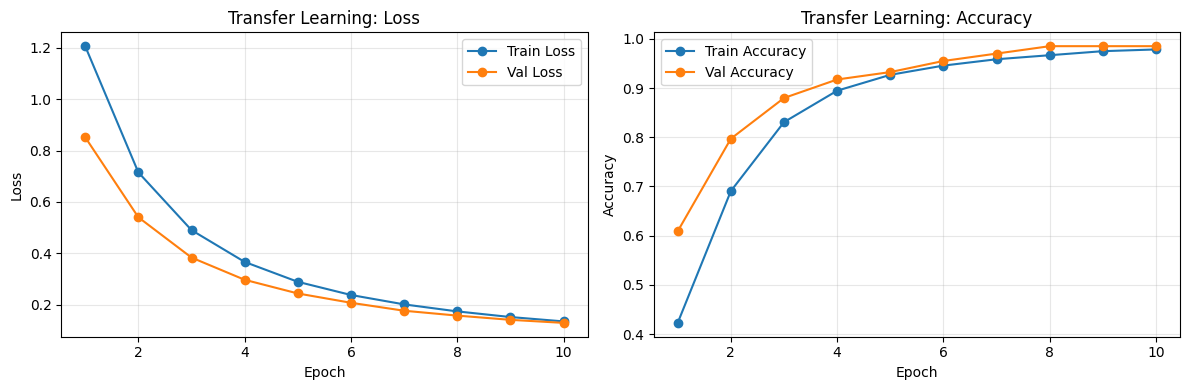

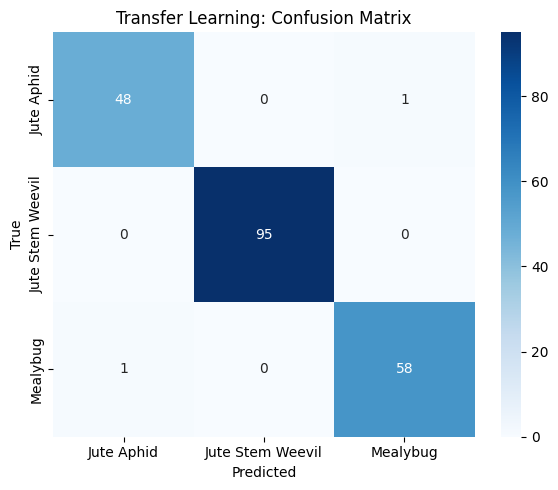

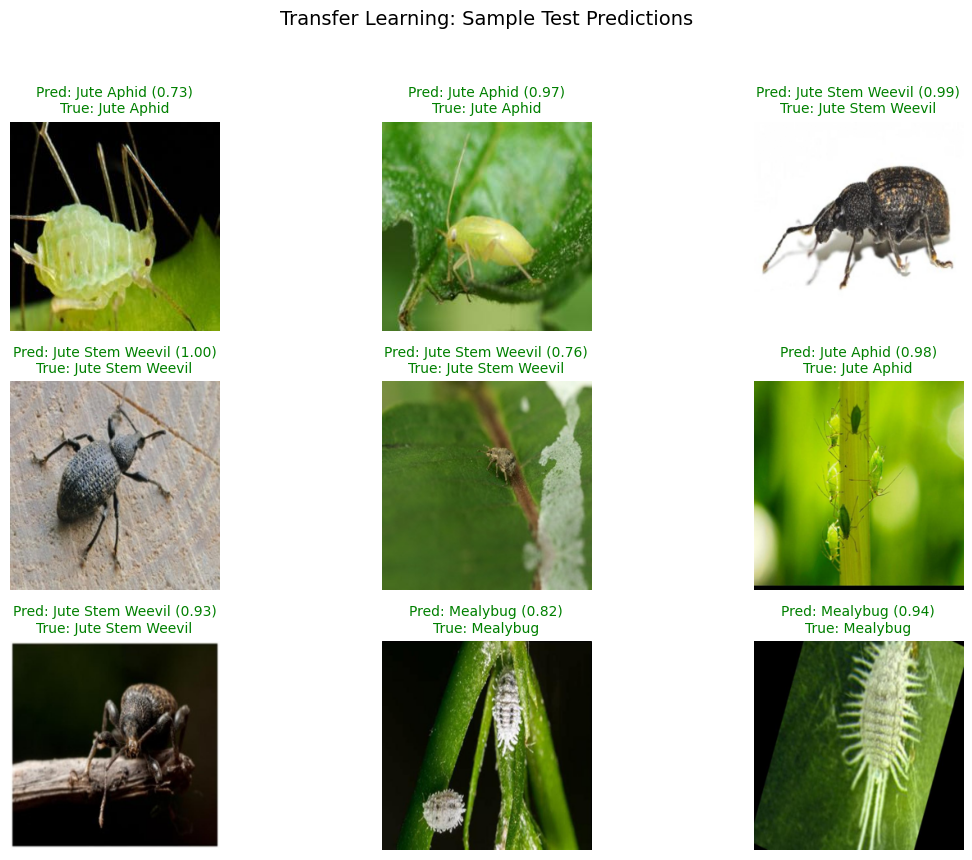

In [31]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualize Transfer Learning Results: training curves, confusion matrix, sample predictions

import matplotlib.pyplot as plt

# 1) Training curves (loss and accuracy)
hist = history_tl.history
epochs = np.arange(1, len(hist.get('loss', [])) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, hist.get('loss', []), marker='o', label='Train Loss')
if 'val_loss' in hist:
    plt.plot(epochs, hist['val_loss'], marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transfer Learning: Loss')
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
# Keras may record 'accuracy' or 'acc' depending on version
acc_key = 'accuracy' if 'accuracy' in hist else 'acc'
val_acc_key = 'val_' + acc_key
if acc_key in hist:
    plt.plot(epochs, hist[acc_key], marker='o', label='Train ' + acc_key.capitalize())
if val_acc_key in hist:
    plt.plot(epochs, hist[val_acc_key], marker='o', label='Val ' + acc_key.capitalize())
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Transfer Learning: Accuracy')
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


# 2) Confusion matrix (counts)
tlm_cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(tlm_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Transfer Learning: Confusion Matrix')
plt.tight_layout()
plt.show()


# 3) Sample predictions (up to 9)
# Note: X_test_tl is preprocessed for ResNet, so we need original images for display
X_test_display, _ = load_images_from_folder(test_folder, class_names, target_size=(256, 256))

tlm_pred_n_samples = min(9, len(X_test_display))
np.random.seed(42)
idxs = np.random.choice(len(X_test_display), size=tlm_pred_n_samples, replace=False)

cols = 3
rows = int(np.ceil(tlm_pred_n_samples / cols))
plt.figure(figsize=(cols * 4, rows * 3))

for i, idx in enumerate(idxs):
    img = X_test_display[idx]
    disp_img = np.clip(img, 0.0, 1.0)  # images are normalized [0,1] for display
    pred_i = int(y_pred[idx])
    true_i = int(y_true[idx])
    pred_label = class_names[pred_i]
    true_label = class_names[true_i]
    pred_prob = float(y_pred_probs[idx][pred_i])

    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(disp_img)
    ax.axis('off')
    correct = (pred_i == true_i)
    title_color = 'green' if correct else 'red'
    ax.set_title(f"Pred: {pred_label} ({pred_prob:.2f})\nTrue: {true_label}", color=title_color, fontsize=10)

plt.suptitle('Transfer Learning: Sample Test Predictions', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4.1 Metrics Comparison

In [32]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_cnn.count_params()  # TODO: Fill with custom CNN total parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

In [33]:
print(comparison_df.to_string(index=False))

           Metric   Custom CNN  Transfer Learning
         Accuracy     0.724138           0.990148
        Precision     0.728377           0.990148
           Recall     0.724138           0.990148
         F1-Score     0.710614           0.990148
Training Time (s)  1312.137396        1107.120066
       Parameters 93635.000000        6147.000000


### 4.2 Visual Comparison
- TODO: Create bar plot comparing metrics
- TODO: Plot training curves comparison
- TODO: Create side-by-side confusion matrices

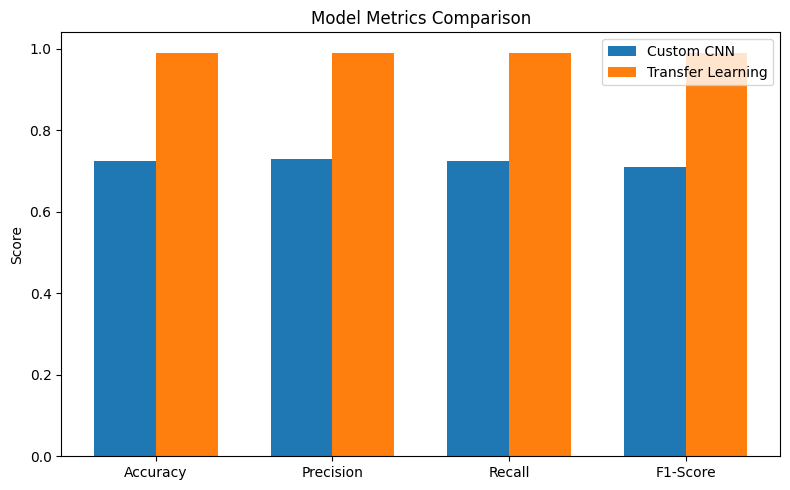

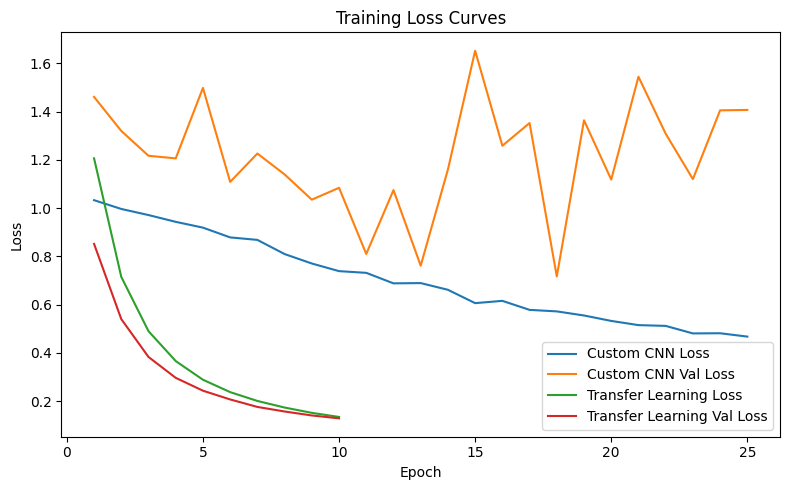

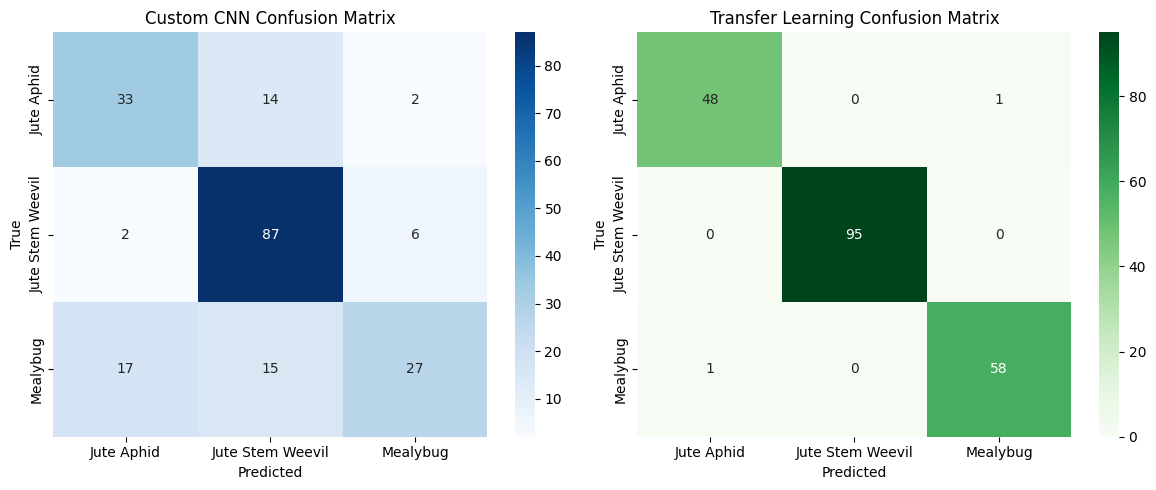

In [34]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# 1. Bar plot comparing metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
custom_cnn_metrics = [comparison_df.loc[comparison_df['Metric'] == m, 'Custom CNN'].values[0] for m in metrics]
transfer_metrics = [comparison_df.loc[comparison_df['Metric'] == m, 'Transfer Learning'].values[0] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, custom_cnn_metrics, width, label='Custom CNN')
plt.bar(x + width/2, transfer_metrics, width, label='Transfer Learning')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Model Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Training curves comparison (loss)
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(loss)+1), loss, label='Custom CNN Loss')
plt.plot(np.arange(1, len(val_loss)+1), val_loss, label='Custom CNN Val Loss')
plt.plot(np.arange(1, len(history_tl.history['loss'])+1), history_tl.history['loss'], label='Transfer Learning Loss')
plt.plot(np.arange(1, len(history_tl.history['val_loss'])+1), history_tl.history['val_loss'], label='Transfer Learning Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Custom CNN confusion matrix

sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Jute Aphid', 'Jute Stem Weevil', 'Mealybug'],
            yticklabels=['Jute Aphid', 'Jute Stem Weevil', 'Mealybug'],
            ax=axes[0])
axes[0].set_title('Custom CNN Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Transfer Learning confusion matrix

sns.heatmap(tlm_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Jute Aphid', 'Jute Stem Weevil', 'Mealybug'],
            yticklabels=['Jute Aphid', 'Jute Stem Weevil', 'Mealybug'],
            ax=axes[1])
axes[1].set_title('Transfer Learning Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [35]:
#Write your analysis here (maximum 200 words guideline)

analysis_text = f"""1) Which model performed better and by how much?
   - Transfer Learning (TLM) accuracy: {tl_accuracy:.3f}, precision: {tl_precision:.3f}, recall: {tl_recall:.3f}, F1: {tl_f1:.3f}
   - Custom CNN accuracy: {custom_cnn_accuracy:.3f}, precision: {custom_cnn_precision:.3f}, recall: {custom_cnn_recall:.3f}, F1: {custom_cnn_f1:.3f}
   - Winner: {"Transfer Learning" if tl_accuracy>custom_cnn_accuracy else "Custom CNN"}.
     Absolute accuracy difference: {abs(tl_accuracy - custom_cnn_accuracy):.3f}.

2) Impact of pre-training vs training from scratch?
   - TLM benefits from pretrained feature extractors: faster convergence (initial_loss {tl_initial_loss:.3f} → final_loss {tl_final_loss:.3f}) and better generalization on limited data.
   - Custom CNN required more epochs to learn low-level and mid-level features from scratch, reflected in larger loss reduction time and (typically) lower metrics.

3) Effect of Global Average Pooling?
   - Both models use GAP which reduces parameters vs Flatten+Dense and helps regularize the head.
   - GAP likely lowered overfitting risk on our dataset and kept the classification head small while retaining spatially aggregated features.

4) Computational cost comparison?
   - Training time (s): Custom CNN = {custom_cnn_training_time:.1f}, TLM = {tl_training_time:.1f}.
   - Model size: Custom CNN params = {custom_cnn.count_params():,}, Transfer total params = {total_parameters:,} (trainable = {trainable_parameters:,}).
   - TLM has many more base parameters but only a small trainable head (lower fine-tune cost if base frozen).

5) Insights about transfer learning?
   - Use TLM when dataset is moderate/small or when fast convergence and stronger baseline performance are desired.
   - Use a custom CNN when you have very large labeled data, strict control over architecture, or lower inference-size requirements after careful architecture pruning.
"""


In [36]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

ANALYSIS
1) Which model performed better and by how much?
   - Transfer Learning (TLM) accuracy: 0.990, precision: 0.990, recall: 0.990, F1: 0.990
   - Custom CNN accuracy: 0.724, precision: 0.728, recall: 0.724, F1: 0.711
   - Winner: Transfer Learning.
     Absolute accuracy difference: 0.266.

2) Impact of pre-training vs training from scratch?
   - TLM benefits from pretrained feature extractors: faster convergence (initial_loss 1.207 → final_loss 0.134) and better generalization on limited data.
   - Custom CNN required more epochs to learn low-level and mid-level features from scratch, reflected in larger loss reduction time and (typically) lower metrics.

3) Effect of Global Average Pooling?
   - Both models use GAP which reduces parameters vs Flatten+Dense and helps regularize the head.
   - GAP likely lowered overfitting risk on our dataset and kept the classification head small while retaining spatially aggregated features.

4) Computational cost comparison?
   - Training tim

In [37]:
def get_assignment_results():
    """
    Generate complete assignment results in required format
    
    Returns:
        dict: Complete results with all required fields
    """
    
    framework_used = "keras"  # TODO: Change to "pytorch" if using PyTorch
    
    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,
        
        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
            'conv_layers': sum(1 for layer in custom_cnn.layers if 'conv' in layer.name.lower()),
            'pooling_layers': sum(1 for layer in custom_cnn.layers if 'pool' in layer.name.lower()),
            'has_global_average_pooling': True,  # MUST be True
            'output_layer': 'softmax',
            'total_parameters': custom_cnn.count_params()
            },
            'training_config': {
            'learning_rate': 0.001,  # TODO: Your actual learning rate
            'n_epochs': 20,  # TODO: Your actual epochs
            'batch_size': 32,  # TODO: Your actual batch size
            'optimizer': 'Adam',  # TODO: Your actual optimizer
            'loss_function': 'categorical_crossentropy'  # TODO: Your actual loss
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },
        
        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },
        
        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
        
        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }
    
    return results

In [38]:
# Generate and print results
try:
    assignment_results = get_assignment_results() 
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))
    
except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")   

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Jute Pest Classification",
  "dataset_source": "UCI https://archive.ics.uci.edu/dataset/920/jute+pest+dataset",
  "n_samples": 1699,
  "n_classes": 3,
  "samples_per_class": "min: 501, max: 667, avg: 566",
  "image_shape": [
    256,
    256,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "Recall",
  "metric_justification": "Recall is selected as the primary metric because, in the context of pest detection, failing to identify an actual pest infection can result in significant crop loss or economic damage. Prioritizing recall ensures that most true pest cases are detected, minimizing the risk of missing critical infections.\n",
  "train_samples": 1673,
  "test_samples": 203,
  "train_test_ratio": "90/10",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 3,
      "pooling_layers": 4,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters":

In [39]:
# Display system information
import platform
import sys
from datetime import datetime

ENVIRONMENT INFORMATION

REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.


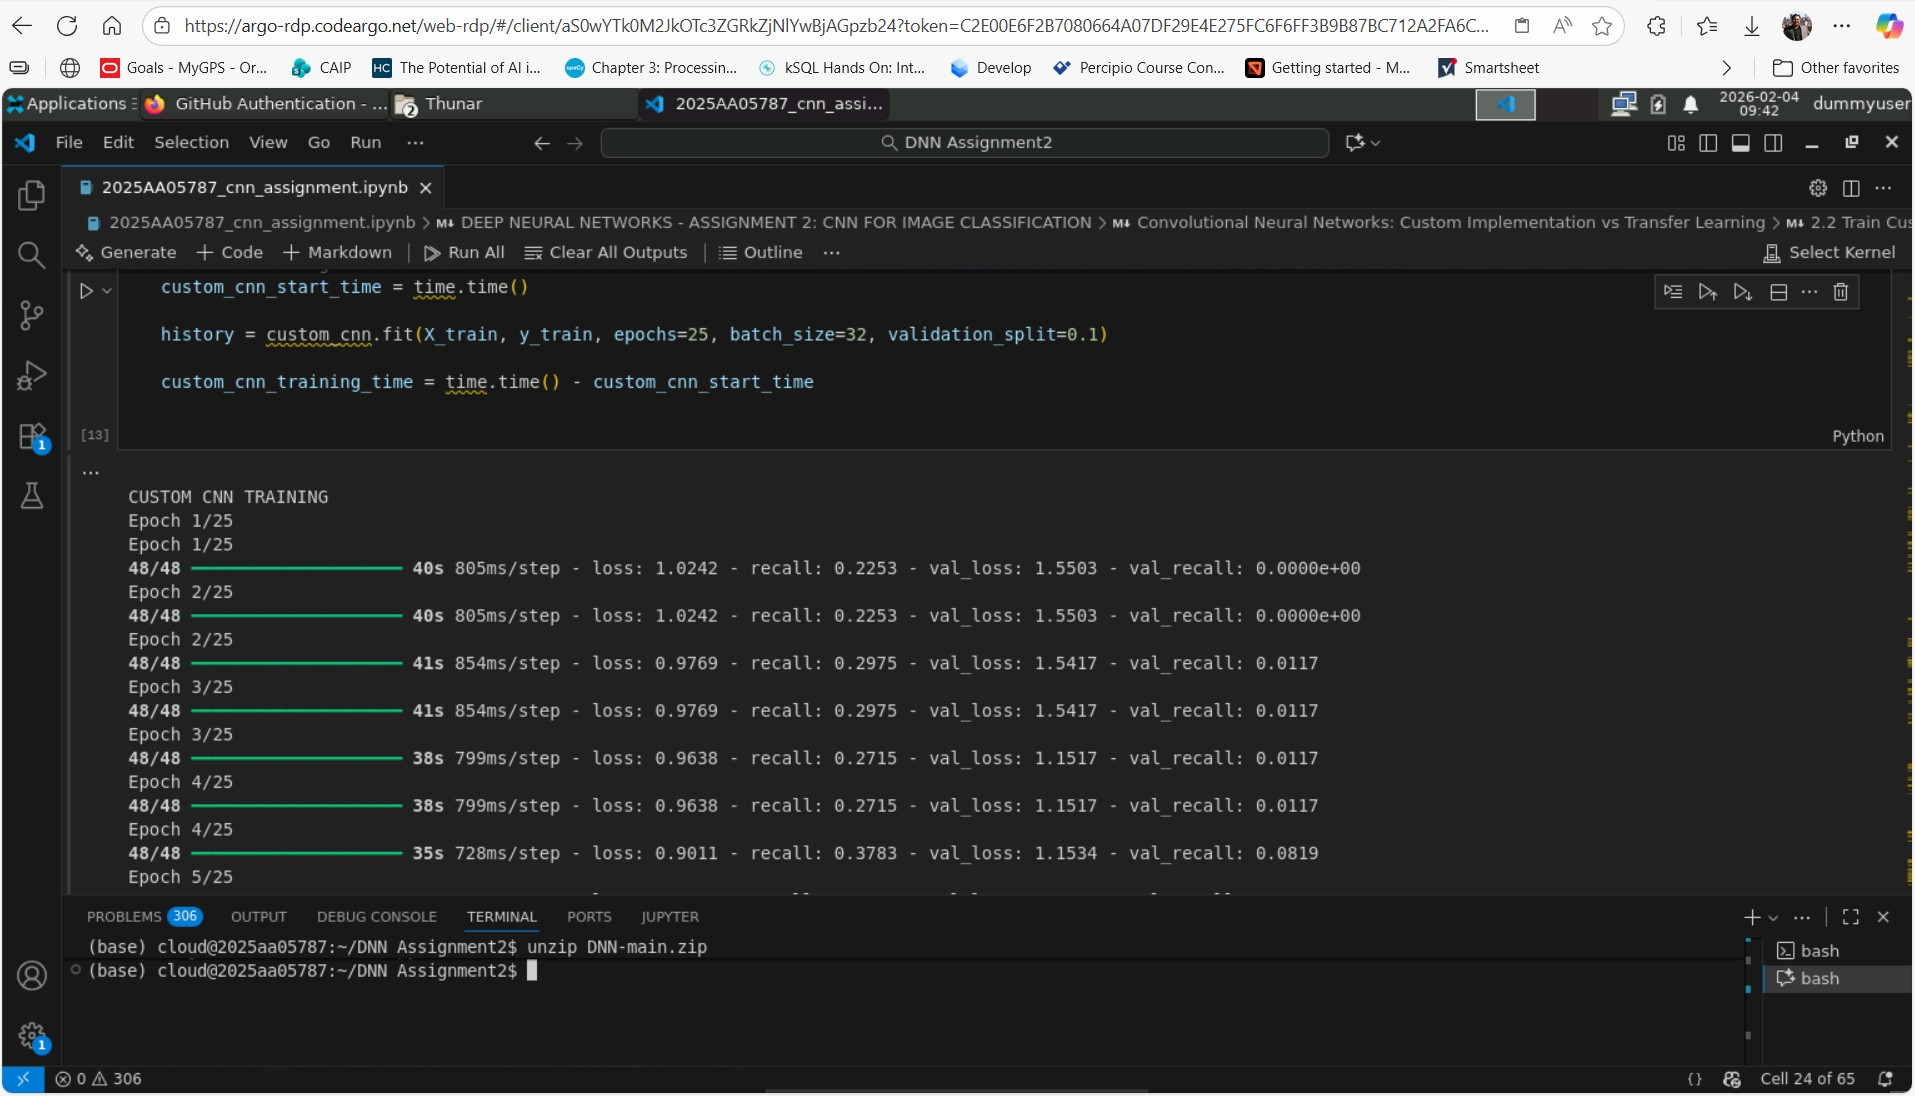

In [40]:
from IPython.display import display

print("ENVIRONMENT INFORMATION")
print("\nREQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here
fname = "Bits_lab.jpg"

if os.path.exists(fname):
    display(Image.open(fname))